# PySpark

Install pyspark if its not already installed using the below code.

In [1]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 MB 3.1 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 13.7 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=40d93d2dea5059b9f6cdad9c96159e95ce0e3237ec81a150e11da1b1dc23273d
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7
Note: you may need to restart the kernel to use updated packages.


# 1. Importing the Libraries

In [5]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf

# For scaling the data
from pyspark.ml.feature import StandardScaler

# For PCA
from pyspark.ml.feature import PCA

# for Clustering
from pyspark.mllib.clustering import KMeans
from pyspark.ml.clustering import KMeans

# for dataframe operations
from pyspark.sql.functions import when, lit, round, col, ceil
from pyspark.sql.types import FloatType

# for evaluating the clustering results
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from numpy import array
from math import sqrt

# for balancing the data
from pyspark.sql.functions import col, explode, array, lit

# import Pipeline
from pyspark.ml import Pipeline

# import LogisticRegression classifier
from pyspark.ml.classification import LogisticRegression

# Import model evaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.sql import SQLContext

# importing the python related libraries for plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## creating the spark Context

In [6]:
spark = SparkSession.builder\
.master("local[*]")\
.appName("ML Implementation")\
.getOrCreate()
sc = spark.sparkContext

We will first import the cleaned dataset exported from the EDA step of R environment.

# 2. Loading the data

In [7]:
# Load and parse the data
ks_df = spark.read.csv("../input/kickstartercleandata/dataClean.csv", header=True, inferSchema=True)
ks_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- category: string (nullable = true)
 |-- main_category: string (nullable = true)
 |-- currency: string (nullable = true)
 |-- deadline: timestamp (nullable = true)
 |-- launched: timestamp (nullable = true)
 |-- state: string (nullable = true)
 |-- backers: integer (nullable = true)
 |-- country: string (nullable = true)
 |-- usd_pledged: double (nullable = true)
 |-- usd_goal: double (nullable = true)
 |-- launch_gap: integer (nullable = true)



In [8]:
ks_df.show()

22/10/03 19:07:42 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , category, main_category, currency, deadline, launched, state, backers, country, usd_pledged, usd_goal, launch_gap
 Schema: _c0, category, main_category, currency, deadline, launched, state, backers, country, usd_pledged, usd_goal, launch_gap
Expected: _c0 but found: 
CSV file: file:///kaggle/input/kickstartercleandata/dataClean.csv
+---+--------------+-------------+--------+-------------------+-------------------+----------+-------+-------+-----------+--------+----------+
|_c0|      category|main_category|currency|           deadline|           launched|     state|backers|country|usd_pledged|usd_goal|launch_gap|
+---+--------------+-------------+--------+-------------------+-------------------+----------+-------+-------+-----------+--------+----------+
|  1|        Poetry|   Publishing|     GBP|2015-10-09 00:00:00|2015-08-11 00:00:00|    failed|      0|     GB|        0.0| 1533.95|        59|

As we don't need some of the columns like launched, deadline and _c0 we will drop them along with the dates

In [9]:
# selecting only the necessary columns
ks_df = ks_df.select(['category', 'main_category','currency','backers','country','usd_pledged','usd_goal','launch_gap','state'])
ks_df.show()

+--------------+-------------+--------+-------+-------+-----------+--------+----------+----------+
|      category|main_category|currency|backers|country|usd_pledged|usd_goal|launch_gap|     state|
+--------------+-------------+--------+-------+-------+-----------+--------+----------+----------+
|        Poetry|   Publishing|     GBP|      0|     GB|        0.0| 1533.95|        59|    failed|
|Narrative Film| Film & Video|     USD|     15|     US|     2421.0| 30000.0|        60|    failed|
|         Music|        Music|     USD|      1|     US|        1.0|  5000.0|        30|    failed|
|  Film & Video| Film & Video|     USD|     14|     US|     1283.0| 19500.0|        56|  canceled|
|          Food|         Food|     USD|     16|     US|     1205.0|  1000.0|        20|successful|
|        Drinks|         Food|     USD|     40|     US|      453.0| 25000.0|        45|    failed|
|    Nonfiction|   Publishing|     CAD|      0|     CA|        0.0| 2406.39|        30|    failed|
|    Indie

In [10]:
# making a list of columns 
all_cols = ks_df.columns
all_cols

['category',
 'main_category',
 'currency',
 'backers',
 'country',
 'usd_pledged',
 'usd_goal',
 'launch_gap',
 'state']

In [11]:
# looking at the modified schema
ks_df.printSchema()

root
 |-- category: string (nullable = true)
 |-- main_category: string (nullable = true)
 |-- currency: string (nullable = true)
 |-- backers: integer (nullable = true)
 |-- country: string (nullable = true)
 |-- usd_pledged: double (nullable = true)
 |-- usd_goal: double (nullable = true)
 |-- launch_gap: integer (nullable = true)
 |-- state: string (nullable = true)



In [12]:
# listing the categorical columns
cat_cols = ['category','main_category','currency','country','state']
cat_cols

['category', 'main_category', 'currency', 'country', 'state']

In [13]:
# listing the category column names after indexing.
cat_cols_indexed = ['category_indexed','main_category_indexed','currency_indexed','country_indexed', 'state_indexed']
cat_cols_indexed

['category_indexed',
 'main_category_indexed',
 'currency_indexed',
 'country_indexed',
 'state_indexed']

## Creating a dataframe with numerical columns.

We are going to perform PCA and do clustering on the PCA columns. As PCA is done on only on the continuous variables, we need to subset the numerical columns.

In [14]:
# selecting only the necessary columns
ks_df_num = ks_df.select(['backers','usd_pledged','usd_goal','launch_gap'])
ks_df_num.show()

+-------+-----------+--------+----------+
|backers|usd_pledged|usd_goal|launch_gap|
+-------+-----------+--------+----------+
|      0|        0.0| 1533.95|        59|
|     15|     2421.0| 30000.0|        60|
|      1|        1.0|  5000.0|        30|
|     14|     1283.0| 19500.0|        56|
|     16|     1205.0|  1000.0|        20|
|     40|      453.0| 25000.0|        45|
|      0|        0.0| 2406.39|        30|
|    100|    12700.0| 12500.0|        30|
|      0|        0.0|  5000.0|        30|
|     11|      664.0|  2500.0|        30|
|     16|      395.0|  1500.0|        30|
|     20|      789.0|  3000.0|        30|
|      7|      250.0|   250.0|        15|
|     40|     1781.0|  5000.0|        30|
|      1|       0.81|  2026.1|        30|
|     12|      650.0|  3500.0|        30|
|      3|       6.29|   65.55|        30|
|     66|     701.66|   175.0|        20|
|      0|        0.0|17489.65|        30|
|     27|      160.6|  142.91|        30|
+-------+-----------+--------+----

# 3. Scale the dataframe with numerical columns

In [15]:
# Creating the dense vector of all the input features using vector assembler
vector_assembler1 = VectorAssembler(inputCols=['backers','usd_pledged','usd_goal','launch_gap'], outputCol='features')

In [16]:
# transforming the data
ks_df_scaled1 = vector_assembler1.transform(ks_df)
ks_df_scaled1.show(2)

+--------------+-------------+--------+-------+-------+-----------+--------+----------+------+--------------------+
|      category|main_category|currency|backers|country|usd_pledged|usd_goal|launch_gap| state|            features|
+--------------+-------------+--------+-------+-------+-----------+--------+----------+------+--------------------+
|        Poetry|   Publishing|     GBP|      0|     GB|        0.0| 1533.95|        59|failed|[0.0,0.0,1533.95,...|
|Narrative Film| Film & Video|     USD|     15|     US|     2421.0| 30000.0|        60|failed|[15.0,2421.0,3000...|
+--------------+-------------+--------+-------+-------+-----------+--------+----------+------+--------------------+
only showing top 2 rows



In [17]:
# Applying scaling on the features vector.
standard_scaler1 = StandardScaler(inputCol='features', outputCol='scaled_features')
ks_df_scaled1 = standard_scaler1.fit(ks_df_scaled1).transform(ks_df_scaled1)
ks_df_scaled1.show(5)

+--------------+-------------+--------+-------+-------+-----------+--------+----------+----------+--------------------+--------------------+
|      category|main_category|currency|backers|country|usd_pledged|usd_goal|launch_gap|     state|            features|     scaled_features|
+--------------+-------------+--------+-------+-------+-----------+--------+----------+----------+--------------------+--------------------+
|        Poetry|   Publishing|     GBP|      0|     GB|        0.0| 1533.95|        59|    failed|[0.0,0.0,1533.95,...|[0.0,0.0,0.209883...|
|Narrative Film| Film & Video|     USD|     15|     US|     2421.0| 30000.0|        60|    failed|[15.0,2421.0,3000...|[0.46868121481658...|
|         Music|        Music|     USD|      1|     US|        1.0|  5000.0|        30|    failed|[1.0,1.0,5000.0,3...|[0.03124541432110...|
|  Film & Video| Film & Video|     USD|     14|     US|     1283.0| 19500.0|        56|  canceled|[14.0,1283.0,1950...|[0.43743580049548...|
|          Fo

## Performing PCA

We will first reduce the number of dimensions to two using the principal component analysis 

In [18]:
#Applying PCA
pca = PCA(k=2, inputCol='scaled_features', outputCol='pca')
model = pca.fit(ks_df_scaled1)

22/10/03 19:07:54 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
22/10/03 19:07:54 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


In [19]:
# transform
ks_df_pca = model.transform(ks_df_scaled1)

In [20]:
# looking at the datatype of the object ks_df_pca
type(ks_df_pca)

pyspark.sql.dataframe.DataFrame

In [21]:
# looking at the important columns
ks_df_pca.select(['features','scaled_features', 'pca', 'state']).show(5)

+--------------------+--------------------+--------------------+----------+
|            features|     scaled_features|                 pca|     state|
+--------------------+--------------------+--------------------+----------+
|[0.0,0.0,1533.95,...|[0.0,0.0,0.209883...|[0.02856884764858...|    failed|
|[15.0,2421.0,3000...|[0.46868121481658...|[-1.4657150622105...|    failed|
|[1.0,1.0,5000.0,3...|[0.03124541432110...|[-0.0996909993557...|    failed|
|[14.0,1283.0,1950...|[0.43743580049548...|[-0.9606680418185...|  canceled|
|[16.0,1205.0,1000...|[0.49992662913769...|[-0.6189404899465...|successful|
+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



In [22]:
# printing the pca vector
ks_df_pca.select(['pca']).show(truncate=False)

+------------------------------------------+
|pca                                       |
+------------------------------------------+
|[0.028568847648582286,3.372932123084174]  |
|[-1.4657150622105009,6.020137995927121]   |
|[-0.09969099935579873,2.105038446183305]  |
|[-0.9606680418185576,4.8249789520753765]  |
|[-0.6189404899465205,1.1164766275575317]  |
|[-1.4656636104404928,4.622127653598314]   |
|[-0.021091096459710225,1.8670630923656177]|
|[-5.2759951069585105,2.3586290389958138]  |
|[-0.07788977029425036,2.109474759656645]  |
|[-0.41085064837459123,1.826587847863104]  |
|[-0.4358998846182843,1.7111196681738103]  |
|[-0.6442839370671787,1.833318002112906]   |
|[-0.1973160357840175,0.8132288408797789]  |
|[-1.3442528323686167,1.9308889666344395]  |
|[-0.034521145088617824,1.8270831111129135]|
|[-0.45115403808663723,1.915626262985533]  |
|[-0.03597678010494318,1.6349654822695618] |
|[-1.5656105566852994,0.817912538776445]   |
|[-0.35140643496533214,3.2768194569632483] |
|[-0.59041

Now, we have completed the PCA and reduced the dimension to two. We will now apply clustering using these principal componenets and try to visualize the clsters formed.

# K-Means Clustering

We will use the K-Means Clustering algorithm to cluster the data

**Plan for Clustering**

1. Find the ideal K-value, which represents the number of clusters.
2. Clustering the data using the observed best k-value
3. Evaluating the cluster results


**Finding out the best value for K(number of clusters)**

In [23]:
# Setting the parameters  and creating the object for the evaluator
eval = ClusteringEvaluator(predictionCol='prediction', featuresCol='pca', metricName='silhouette', distanceMeasure='squaredEuclidean')

In [24]:
# Trying different possible k-values and finding out the silhouette score for each of those k-values.
silhouette_score = []
print("""
Silhoutte Scores for K Mean Clustering
=======================================
Model\tScore\t
=====\t=====\t
""")
for k in range(2,11):
    kmeans_algo = KMeans(featuresCol='pca', k=k)
    kmeans_fit = kmeans_algo.fit(ks_df_pca)
    output = kmeans_fit.transform(ks_df_pca)
    score = eval.evaluate(output)
    silhouette_score.append(score)
    #print(f"K{k}\t {round(score,2)}\t")
    print(f"K{k}\t", score,"\t")


Silhoutte Scores for K Mean Clustering
Model	Score	
=====	=====	



K2	 0.45459918768289 	


K3	 0.667545989095942 	


K4	 0.6530319355541722 	


K5	 0.5859384385291145 	


K6	 0.5750123513907744 	


K7	 0.5566814480304052 	


K8	 0.5645861177465018 	


K9	 0.5676419326616353 	


K10	 0.5670649197617107 	


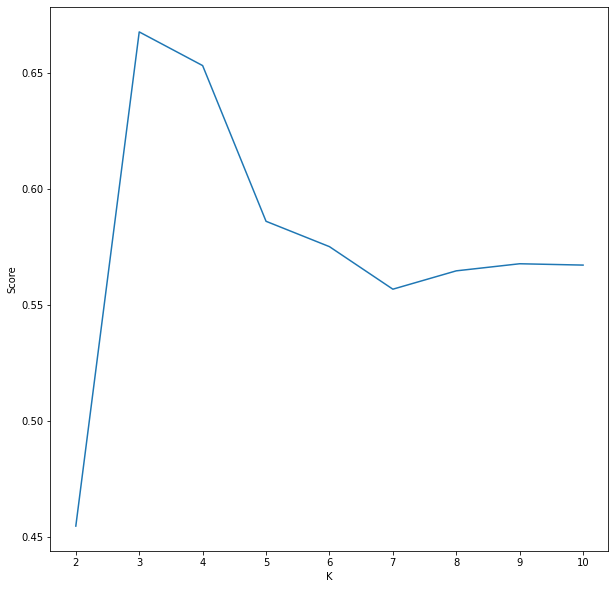

In [25]:
# Plotting the silhouette scores to identify the best k value
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.plot(range(2,11), silhouette_score)
ax.set_xlabel('K')
ax.set_ylabel('Score');

From the above silhoutte scores it is clear that at k=2 we have the best score. As this is a plot of Silhoutte score vs K we need to take the global maxima. So, we wil consider the best number of clusters as 2.

Now, lets cluster the data with k=2

**Train and Evaluate**

In [26]:
# Clustering the data using k=3
kmeans = KMeans(featuresCol = 'pca', k=2)
model = kmeans.fit(ks_df_pca)
ks_df_cls = model.transform(ks_df_pca)

In [27]:
# Evaluating the silihoutte score of the cluster
eval = ClusteringEvaluator(featuresCol='pca', metricName='silhouette', distanceMeasure='squaredEuclidean')
silhouette = eval.evaluate(ks_df_cls)
print(f"Silhouette with squared euclidean distance: {silhouette}")

Silhouette with squared euclidean distance: 0.45459918768289


In [28]:
# Looking at the cluster centers
centers = model.clusterCenters()
print('Cluster Centers:')
for center in centers:
    print(center)

Cluster Centers:
[-1.10726381  1.81901438]
[-0.85962897  3.75835409]


In [29]:
ks_df_cls.show()

+--------------+-------------+--------+-------+-------+-----------+--------+----------+----------+--------------------+--------------------+--------------------+----------+
|      category|main_category|currency|backers|country|usd_pledged|usd_goal|launch_gap|     state|            features|     scaled_features|                 pca|prediction|
+--------------+-------------+--------+-------+-------+-----------+--------+----------+----------+--------------------+--------------------+--------------------+----------+
|        Poetry|   Publishing|     GBP|      0|     GB|        0.0| 1533.95|        59|    failed|[0.0,0.0,1533.95,...|[0.0,0.0,0.209883...|[0.02856884764858...|         1|
|Narrative Film| Film & Video|     USD|     15|     US|     2421.0| 30000.0|        60|    failed|[15.0,2421.0,3000...|[0.46868121481658...|[-1.4657150622105...|         1|
|         Music|        Music|     USD|      1|     US|        1.0|  5000.0|        30|    failed|[1.0,1.0,5000.0,3...|[0.0312454143211

In [30]:
# Column names for splitting the pca vector
column_names = ['pc1', 'pc2']
column_names

['pc1', 'pc2']

In [31]:
# Selecting only pca and state colummns for plotting.
ks_df_sub = ks_df_pca.select('pca','state')
ks_df_sub.show(5, truncate=False)


+----------------------------------------+----------+
|pca                                     |state     |
+----------------------------------------+----------+
|[0.028568847648582286,3.372932123084174]|failed    |
|[-1.4657150622105009,6.020137995927121] |failed    |
|[-0.09969099935579873,2.105038446183305]|failed    |
|[-0.9606680418185576,4.8249789520753765]|canceled  |
|[-0.6189404899465205,1.1164766275575317]|successful|
+----------------------------------------+----------+
only showing top 5 rows



In [32]:
#Splitting the vactor pca in to pc0 and pc1
from pyspark.sql.functions import udf, col
from pyspark.sql.types import ArrayType, DoubleType

def to_array(col):
    def to_array_(v):
        return v.toArray().tolist()
    # Important: asNondeterministic requires Spark 2.3 or later
    # It can be safely removed i.e.
    # return udf(to_array_, ArrayType(DoubleType()))(col)
    # but at the cost of decreased performance
    return udf(to_array_, ArrayType(DoubleType())).asNondeterministic()(col)

ks_df_sub1 = (ks_df_sub
    .withColumn("pc", to_array(col("pca")))
    .select(["state"] + [col("pc")[i] for i in range(2)]))

In [33]:
ks_df_sub1.show(5, truncate=False)

+----------+--------------------+------------------+
|state     |pc[0]               |pc[1]             |
+----------+--------------------+------------------+
|failed    |0.028568847648582286|3.372932123084174 |
|failed    |-1.4657150622105009 |6.020137995927121 |
|failed    |-0.09969099935579873|2.105038446183305 |
|canceled  |-0.9606680418185576 |4.8249789520753765|
|successful|-0.6189404899465205 |1.1164766275575317|
+----------+--------------------+------------------+
only showing top 5 rows



<AxesSubplot:xlabel='pc[0]', ylabel='pc[1]'>

/opt/conda/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


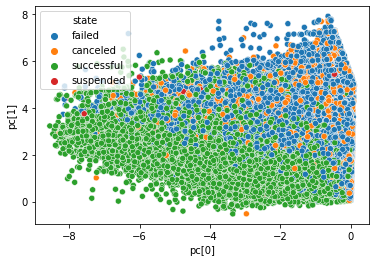

In [34]:
# Plotting the formed clusters
ks_df_sub2 = ks_df_sub1.toPandas()
sns.scatterplot(x='pc[0]', y='pc[1]', data=ks_df_sub2, hue='state')

As the clusters seems to be inseparable, let's look at the Silhouette Coefficient of the clusters and decide what's going on. 

In [35]:
# Evaluating the silihoutte score of the cluster
eval = ClusteringEvaluator()
silhouette1 = eval.evaluate(ks_df_cls)
print(f"Silhouette with squared euclidean distance: {silhouette1}")

Silhouette with squared euclidean distance: 0.5082128353607227


The Silhouette coefficient near to zero indicates that the clusters are inseparable or barely separable. It can be also be represented as the distance between the clusters is insignificant. But the score here is less than 0.4 so, we can conclude that the clusters are identifiable but the distance between them is not significant.

# Machine Learning Implementation.

In the machine learning implementation we are going to use the multinomial Logistic Regression algorithm. As our data is having four different classes, we are going to use the technique of passing weights of the classes to the Logistic Regression algorithm to balance the dataset. 

**Plan for Machine Learning Implementation**
1. One-hot encode the categorical columns
2. Scale the data
3. Calculate the weights of the classes
4. Apply the multinomial Logistic Regression algorithm

In [36]:
# Looking into the dataframe we need to model
ks_df.show(5)

+--------------+-------------+--------+-------+-------+-----------+--------+----------+----------+
|      category|main_category|currency|backers|country|usd_pledged|usd_goal|launch_gap|     state|
+--------------+-------------+--------+-------+-------+-----------+--------+----------+----------+
|        Poetry|   Publishing|     GBP|      0|     GB|        0.0| 1533.95|        59|    failed|
|Narrative Film| Film & Video|     USD|     15|     US|     2421.0| 30000.0|        60|    failed|
|         Music|        Music|     USD|      1|     US|        1.0|  5000.0|        30|    failed|
|  Film & Video| Film & Video|     USD|     14|     US|     1283.0| 19500.0|        56|  canceled|
|          Food|         Food|     USD|     16|     US|     1205.0|  1000.0|        20|successful|
+--------------+-------------+--------+-------+-------+-----------+--------+----------+----------+
only showing top 5 rows



## One-Hot Encoding the categorical columns.

As there are many categorical columns, let's encode them using the one-hot encoder

In [37]:
# Creating the String indexer and fitting the data to it.
indexer = StringIndexer(inputCols=cat_cols, outputCols=cat_cols_indexed)
ks_df = indexer.fit(ks_df).transform(ks_df)
ks_df.show()

+--------------+-------------+--------+-------+-------+-----------+--------+----------+----------+----------------+---------------------+----------------+---------------+-------------+
|      category|main_category|currency|backers|country|usd_pledged|usd_goal|launch_gap|     state|category_indexed|main_category_indexed|currency_indexed|country_indexed|state_indexed|
+--------------+-------------+--------+-------+-------+-----------+--------+----------+----------+----------------+---------------------+----------------+---------------+-------------+
|        Poetry|   Publishing|     GBP|      0|     GB|        0.0| 1533.95|        59|    failed|            58.0|                  2.0|             1.0|            1.0|          0.0|
|Narrative Film| Film & Video|     USD|     15|     US|     2421.0| 30000.0|        60|    failed|            27.0|                  0.0|             0.0|            0.0|          0.0|
|         Music|        Music|     USD|      1|     US|        1.0|  5000.0

In [38]:
# listing the category column names before encoding
cat_cols_indexed_be = ['category_indexed','main_category_indexed','currency_indexed','country_indexed']
cat_cols_indexed

# listing the category column names after encoding.
cat_cols_indexed_ae = ['category_indexed_O','main_category_indexed_O','currency_indexed_O','country_indexed_O']
cat_cols_indexed_ae

['category_indexed_O',
 'main_category_indexed_O',
 'currency_indexed_O',
 'country_indexed_O']

In [39]:
# One Hot encoding implementation using the indexed columns
encoder = OneHotEncoder(inputCols=cat_cols_indexed_be, outputCols=cat_cols_indexed_ae)
model =encoder.fit(ks_df)
ks_df = model.transform(ks_df)
ks_df.show()

+--------------+-------------+--------+-------+-------+-----------+--------+----------+----------+----------------+---------------------+----------------+---------------+-------------+------------------+-----------------------+------------------+-----------------+
|      category|main_category|currency|backers|country|usd_pledged|usd_goal|launch_gap|     state|category_indexed|main_category_indexed|currency_indexed|country_indexed|state_indexed|category_indexed_O|main_category_indexed_O|currency_indexed_O|country_indexed_O|
+--------------+-------------+--------+-------+-------+-----------+--------+----------+----------+----------------+---------------------+----------------+---------------+-------------+------------------+-----------------------+------------------+-----------------+
|        Poetry|   Publishing|     GBP|      0|     GB|        0.0| 1533.95|        59|    failed|            58.0|                  2.0|             1.0|            1.0|          0.0|  (158,[58],[1.0])|  

Now lets drop the cat_cols_indexed from our dataframe ks_df

In [40]:
# selecting only the necessary columns
ks_df = ks_df.select(['category', 'main_category','currency','backers','country','usd_pledged','usd_goal','launch_gap','state', 'category_indexed_O','main_category_indexed_O','currency_indexed_O','country_indexed_O'])
ks_df.show()

+--------------+-------------+--------+-------+-------+-----------+--------+----------+----------+------------------+-----------------------+------------------+-----------------+
|      category|main_category|currency|backers|country|usd_pledged|usd_goal|launch_gap|     state|category_indexed_O|main_category_indexed_O|currency_indexed_O|country_indexed_O|
+--------------+-------------+--------+-------+-------+-----------+--------+----------+----------+------------------+-----------------------+------------------+-----------------+
|        Poetry|   Publishing|     GBP|      0|     GB|        0.0| 1533.95|        59|    failed|  (158,[58],[1.0])|         (14,[2],[1.0])|    (13,[1],[1.0])|   (21,[1],[1.0])|
|Narrative Film| Film & Video|     USD|     15|     US|     2421.0| 30000.0|        60|    failed|  (158,[27],[1.0])|         (14,[0],[1.0])|    (13,[0],[1.0])|   (21,[0],[1.0])|
|         Music|        Music|     USD|      1|     US|        1.0|  5000.0|        30|    failed|   (158

As we have different ranges of values in the numerical columns we need to scale the data inorder to overcome the bias while machine learning model training.

### Scaling the data

In [41]:
# making a list of columns 
inputcols = ['backers','usd_pledged','usd_goal','launch_gap','category_indexed_O','main_category_indexed_O','currency_indexed_O','country_indexed_O']
inputcols

['backers',
 'usd_pledged',
 'usd_goal',
 'launch_gap',
 'category_indexed_O',
 'main_category_indexed_O',
 'currency_indexed_O',
 'country_indexed_O']

In [42]:
# Creating the dense vector of all the input features using vector assembler
vector_assembler = VectorAssembler(inputCols=inputcols, outputCol='features')

In [43]:
# transforming the data
ks_df_scaled = vector_assembler.transform(ks_df)
ks_df_scaled.show(2)

+--------------+-------------+--------+-------+-------+-----------+--------+----------+------+------------------+-----------------------+------------------+-----------------+--------------------+
|      category|main_category|currency|backers|country|usd_pledged|usd_goal|launch_gap| state|category_indexed_O|main_category_indexed_O|currency_indexed_O|country_indexed_O|            features|
+--------------+-------------+--------+-------+-------+-----------+--------+----------+------+------------------+-----------------------+------------------+-----------------+--------------------+
|        Poetry|   Publishing|     GBP|      0|     GB|        0.0| 1533.95|        59|failed|  (158,[58],[1.0])|         (14,[2],[1.0])|    (13,[1],[1.0])|   (21,[1],[1.0])|(210,[2,3,62,164,...|
|Narrative Film| Film & Video|     USD|     15|     US|     2421.0| 30000.0|        60|failed|  (158,[27],[1.0])|         (14,[0],[1.0])|    (13,[0],[1.0])|   (21,[0],[1.0])|(210,[0,1,2,3,31,...|
+--------------+----

We will use the standardscaler from the pyspark.ml.feature

In [44]:
# Applying scaling on the features vector.
standard_scaler = StandardScaler(inputCol='features', outputCol='scaled_features')
ks_df_scaled = standard_scaler.fit(ks_df_scaled).transform(ks_df_scaled)
ks_df_scaled.show(5)

+--------------+-------------+--------+-------+-------+-----------+--------+----------+----------+------------------+-----------------------+------------------+-----------------+--------------------+--------------------+
|      category|main_category|currency|backers|country|usd_pledged|usd_goal|launch_gap|     state|category_indexed_O|main_category_indexed_O|currency_indexed_O|country_indexed_O|            features|     scaled_features|
+--------------+-------------+--------+-------+-------+-----------+--------+----------+----------+------------------+-----------------------+------------------+-----------------+--------------------+--------------------+
|        Poetry|   Publishing|     GBP|      0|     GB|        0.0| 1533.95|        59|    failed|  (158,[58],[1.0])|         (14,[2],[1.0])|    (13,[1],[1.0])|   (21,[1],[1.0])|(210,[2,3,62,164,...|(210,[2,3,62,164,...|
|Narrative Film| Film & Video|     USD|     15|     US|     2421.0| 30000.0|        60|    failed|  (158,[27],[1.0])

In [45]:
# Slicing the dataframe to have only the scaled_features and labels.
ks_df_ss = ks_df_scaled.selectExpr("scaled_features as features", "state as state")
ks_df_ss.show(10)

+--------------------+----------+
|            features|     state|
+--------------------+----------+
|(210,[2,3,62,164,...|    failed|
|(210,[0,1,2,3,31,...|    failed|
|(210,[0,1,2,3,7,1...|    failed|
|(210,[0,1,2,3,15,...|  canceled|
|(210,[0,1,2,3,8,1...|successful|
|(210,[0,1,2,3,52,...|    failed|
|(210,[2,3,14,164,...|    failed|
|(210,[0,1,2,3,21,...|successful|
|(210,[2,3,24,174,...|    failed|
|(210,[0,1,2,3,34,...|    failed|
+--------------------+----------+
only showing top 10 rows



## Inspecting the Balance of the dataset

As we are dealing with a multi-class classification, we need to look at the balance of the dataset and try to balance it if it is imbalanced. 

In [46]:
ks_df_ss.groupBy('state').count().orderBy(col('count').desc()).show()

+----------+------+
|     state| count|
+----------+------+
|    failed|164070|
|successful| 92813|
|  canceled| 29360|
| suspended|  1400|
+----------+------+



As we have an imbalanced dataset. Let's try to balance it using Oversampling technique

# Balancing the data using Oversampling

In [47]:
# Calculating the ratio of weights to oversample
failed_df = ks_df_ss.filter(col("state") == 'failed')
successful_df = ks_df_ss.filter(col("state") == 'successful')
canceled_df = ks_df_ss.filter(col("state") == 'canceled')
suspended_df = ks_df_ss.filter(col("state") == 'suspended')

ratio_fai_suc = int(failed_df.count()/successful_df.count())
ratio_fai_can = int(failed_df.count()/canceled_df.count())
ratio_fai_sus = int(failed_df.count()/suspended_df.count())

print("ratio_fai_suc: {}".format(ratio_fai_suc))
print("ratio_fai_can: {}".format(ratio_fai_can))
print("ratio_fai_sus: {}".format(ratio_fai_sus))

ratio_fai_suc: 1
ratio_fai_can: 5
ratio_fai_sus: 117


The actual 'failed' state records are almost 2 times higher than the 'successful' records. As we got the ratio of successful projects to the failed classes as 1, we need to inspect the actual float number before rounding off and try to round it off to a higher number. To balance the data better.

In [48]:
# Inspecting the actual ration in float
ratio_fai_suc1 = float(failed_df.count()/successful_df.count())
print(ratio_fai_suc1)

1.7677480525357439


As the ratio is 1.76 which can be rounded of to 2 to balance the data better, we will use ratio_fai_suc+1 to oversample the data.

## Oversampling the data

In [49]:
# duplicate the minority rows in Successful state
os_suc_df = successful_df.withColumn("dummy", explode(array([lit(x) for x in range(int(ratio_fai_suc+1))]))).drop('dummy')
# combine both oversampled successful rows and previous majority rows 
failed_succ_df = failed_df.unionAll(os_suc_df)

# duplicate the minority rows in Canceled state
os_can_df = canceled_df.withColumn("dummy", explode(array([lit(x) for x in range(ratio_fai_can)]))).drop('dummy')
# combine both oversampled canceled rows and previous majority rows 
failed_succ_can_df = failed_succ_df.unionAll(os_can_df)

# duplicate the minority rows in Suspended state
os_sus_df = suspended_df.withColumn("dummy", explode(array([lit(x) for x in range(ratio_fai_sus)]))).drop('dummy')
# combine both oversampled suspended rows and previous majority rows 
ks_df_os = failed_succ_can_df.unionAll(os_sus_df)


ks_df_os.show()

+--------------------+------+
|            features| state|
+--------------------+------+
|(210,[2,3,62,164,...|failed|
|(210,[0,1,2,3,31,...|failed|
|(210,[0,1,2,3,7,1...|failed|
|(210,[0,1,2,3,52,...|failed|
|(210,[2,3,14,164,...|failed|
|(210,[2,3,24,174,...|failed|
|(210,[0,1,2,3,34,...|failed|
|(210,[0,1,2,3,41,...|failed|
|(210,[0,1,2,3,45,...|failed|
|(210,[0,1,2,3,8,1...|failed|
|(210,[0,1,2,3,106...|failed|
|(210,[0,1,2,3,16,...|failed|
|(210,[0,1,2,3,52,...|failed|
|(210,[2,3,70,174,...|failed|
|(210,[0,1,2,3,63,...|failed|
|(210,[0,1,2,3,36,...|failed|
|(210,[0,1,2,3,22,...|failed|
|(210,[0,1,2,3,35,...|failed|
|(210,[0,1,2,3,10,...|failed|
|(210,[2,3,6,162,1...|failed|
+--------------------+------+
only showing top 20 rows



In [50]:
# inspecting the balance of the data after oversampling.
ks_df_os.groupBy('state').count().orderBy(col('count').desc()).show()

+----------+------+
|     state| count|
+----------+------+
|successful|185626|
|    failed|164070|
| suspended|163800|
|  canceled|146800|
+----------+------+



Now the data looks quite balanced with an acceptable variation among the counts.

## Indexing the State column

In [51]:
# Creating the String indexer and fitting state column to it
indexer = StringIndexer(inputCol='state', outputCol='state_indexed')
ks_df_sliced = indexer.fit(ks_df_os).transform(ks_df_os)
ks_df_sliced.show()

+--------------------+------+-------------+
|            features| state|state_indexed|
+--------------------+------+-------------+
|(210,[2,3,62,164,...|failed|          1.0|
|(210,[0,1,2,3,31,...|failed|          1.0|
|(210,[0,1,2,3,7,1...|failed|          1.0|
|(210,[0,1,2,3,52,...|failed|          1.0|
|(210,[2,3,14,164,...|failed|          1.0|
|(210,[2,3,24,174,...|failed|          1.0|
|(210,[0,1,2,3,34,...|failed|          1.0|
|(210,[0,1,2,3,41,...|failed|          1.0|
|(210,[0,1,2,3,45,...|failed|          1.0|
|(210,[0,1,2,3,8,1...|failed|          1.0|
|(210,[0,1,2,3,106...|failed|          1.0|
|(210,[0,1,2,3,16,...|failed|          1.0|
|(210,[0,1,2,3,52,...|failed|          1.0|
|(210,[2,3,70,174,...|failed|          1.0|
|(210,[0,1,2,3,63,...|failed|          1.0|
|(210,[0,1,2,3,36,...|failed|          1.0|
|(210,[0,1,2,3,22,...|failed|          1.0|
|(210,[0,1,2,3,35,...|failed|          1.0|
|(210,[0,1,2,3,10,...|failed|          1.0|
|(210,[2,3,6,162,1...|failed|   

In [52]:
ks_df_sliced.filter(ks_df_sliced.state_indexed==0).show(1)
ks_df_sliced.filter(ks_df_sliced.state_indexed==1).show(1)
ks_df_sliced.filter(ks_df_sliced.state_indexed==2).show(1)
ks_df_sliced.filter(ks_df_sliced.state_indexed==3).show(1)

+--------------------+----------+-------------+
|            features|     state|state_indexed|
+--------------------+----------+-------------+
|(210,[0,1,2,3,8,1...|successful|          0.0|
+--------------------+----------+-------------+
only showing top 1 row

+--------------------+------+-------------+
|            features| state|state_indexed|
+--------------------+------+-------------+
|(210,[2,3,62,164,...|failed|          1.0|
+--------------------+------+-------------+
only showing top 1 row



+--------------------+---------+-------------+
|            features|    state|state_indexed|
+--------------------+---------+-------------+
|(210,[0,1,2,3,24,...|suspended|          2.0|
+--------------------+---------+-------------+
only showing top 1 row



+--------------------+--------+-------------+
|            features|   state|state_indexed|
+--------------------+--------+-------------+
|(210,[0,1,2,3,15,...|canceled|          3.0|
+--------------------+--------+-------------+
only showing top 1 row



From the above step it is clear that we have labels setup as below.

0 --> successful

1 --> failed

2 --> suspended

3 --> canceled

In [53]:
# Slicing the dataframe to have only the scaled_features and labels.
ks_df_sliced = ks_df_sliced.selectExpr("features as features", "state_indexed as labels")
ks_df_sliced.show(10)

+--------------------+------+
|            features|labels|
+--------------------+------+
|(210,[2,3,62,164,...|   1.0|
|(210,[0,1,2,3,31,...|   1.0|
|(210,[0,1,2,3,7,1...|   1.0|
|(210,[0,1,2,3,52,...|   1.0|
|(210,[2,3,14,164,...|   1.0|
|(210,[2,3,24,174,...|   1.0|
|(210,[0,1,2,3,34,...|   1.0|
|(210,[0,1,2,3,41,...|   1.0|
|(210,[0,1,2,3,45,...|   1.0|
|(210,[0,1,2,3,8,1...|   1.0|
+--------------------+------+
only showing top 10 rows



In [54]:
#Checking the datatypes
ks_df_sliced.printSchema()

root
 |-- features: vector (nullable = true)
 |-- labels: double (nullable = false)



The weight column is read as string. we need to change it to float

## Splitting the dataset into train and test sets

Now, we will split the dataset in to train and test sets randomly.

In [55]:
train, test = ks_df_sliced.randomSplit([0.75, 0.25], seed = 100)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 495404


Test Dataset Count: 164892


In [56]:
test.groupBy('labels').count().orderBy(col('count').desc()).show()

+------+-----+
|labels|count|
+------+-----+
|   0.0|46459|
|   1.0|40874|
|   2.0|40715|
|   3.0|36844|
+------+-----+



## Logistic Regression Classifier

In [57]:
# configuring and training the Logistic Regression classifier using the training data
lr = LogisticRegression(featuresCol = 'features', labelCol = 'labels', maxIter=10)
#lr.setWeightCol("weight")
lrModel = lr.fit(train)


22/10/03 19:11:21 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/10/03 19:11:21 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [58]:
# Print the coefficients and intercept for multinomial logistic regression
print("Coefficients: \n" + str(lrModel.coefficientMatrix))
print("Intercept: " + str(lrModel.interceptVector))

Coefficients: 
DenseMatrix([[ 1.83194315e+00,  1.47538633e+00, -3.99692568e+00,
              -8.62932164e-02, -2.49367756e-01,  1.88505324e-01,
               6.59039597e-02,  3.77610796e-02, -5.41599750e-02,
               7.83205861e-04, -1.81994662e-01,  2.45678660e-02,
              -1.40412523e-02, -5.83743470e-02,  1.41958441e-02,
               4.52576573e-02,  2.69111669e-02,  6.46057763e-02,
              -5.18007297e-03,  1.40616811e-01,  4.07892338e-02,
               1.44365333e-01, -2.53839709e-02, -8.75447522e-03,
              -1.64555627e-02,  3.13307686e-02,  1.19236048e-02,
               6.49396609e-02,  5.78586352e-02, -8.84091399e-02,
              -3.16141571e-02,  1.57325438e-01,  5.03155187e-02,
               4.27463752e-02, -5.64120021e-02,  1.97062478e-02,
               9.72925726e-03,  8.70942545e-03,  2.85740291e-02,
               5.46337425e-02,  3.54183404e-02,  1.00169417e-02,
               1.30226368e-01,  1.99465744e-02,  2.62674489e-02,
          

# Performance Metrics

In [59]:
# Getting the training summary.
trainingSummary = lrModel.summary

In [60]:
# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
print("objectiveHistory:")
for objective in objectiveHistory:
    print(objective)

# for multiclass, we can inspect metrics on a per-label basis
print("False positive rate by label:")
for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("True positive rate by label:")
for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("Precision by label:")
for i, prec in enumerate(trainingSummary.precisionByLabel):
    print("label %d: %s" % (i, prec))

print("Recall by label:")
for i, rec in enumerate(trainingSummary.recallByLabel):
    print("label %d: %s" % (i, rec))

print("F-measure by label:")
for i, f in enumerate(trainingSummary.fMeasureByLabel()):
    print("label %d: %s" % (i, f))

accuracy = trainingSummary.accuracy
falsePositiveRate = trainingSummary.weightedFalsePositiveRate
truePositiveRate = trainingSummary.weightedTruePositiveRate
fMeasure = trainingSummary.weightedFMeasure()
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
          % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))
# $example off$

objectiveHistory:
1.3828129686577755
1.0864949215846
1.0212054117455254
0.9869598065715494
0.9594950635581073
0.9406713291673551
0.9292214855219362
0.9210800887181364
0.9082744605720608
0.9060355908839319
0.8993176849021834
False positive rate by label:


label 0: 0.06488657831724386
label 1: 0.1873119331126682
label 2: 0.1830231602469925
label 3: 0.09527614619870904
True positive rate by label:
label 0: 0.928539093319537
label 1: 0.5140183122828663
label 2: 0.6115611163017427
label 3: 0.2717632507548474
Precision by label:
label 0: 0.8482640461608145
label 1: 0.47597035567180784
label 2: 0.524861069468752
label 3: 0.44863826081734376
Recall by label:
label 0: 0.928539093319537
label 1: 0.5140183122828663
label 2: 0.6115611163017427
label 3: 0.2717632507548474
F-measure by label:
label 0: 0.8865881771776718
label 1: 0.4942631907586638
label 2: 0.5649038281138604
label 3: 0.33848733022960775
Accuracy: 0.6009297462273215
FPR: 0.13142756410293513
TPR: 0.6009297462273215
F-measure: 0.5874497692148442
Precision: 0.5866343424586788
Recall: 0.6009297462273215


# Testing with the test dataset

In [61]:
predictions = lrModel.transform(test)
predictions.show(5)

+--------------------+------+--------------------+--------------------+----------+
|            features|labels|       rawPrediction|         probability|prediction|
+--------------------+------+--------------------+--------------------+----------+
|(210,[0,1,2,3,4,1...|   1.0|[-2.5485991466828...|[0.01035979550114...|       2.0|
|(210,[0,1,2,3,4,1...|   1.0|[-4.4052875506814...|[9.03655825220715...|       2.0|
|(210,[0,1,2,3,4,1...|   1.0|[-5.0642592970803...|[3.77578075955678...|       2.0|
|(210,[0,1,2,3,4,1...|   1.0|[-5.5205756154797...|[2.06088621800212...|       2.0|
|(210,[0,1,2,3,4,1...|   1.0|[-7.7986725040341...|[1.00032553348627...|       3.0|
+--------------------+------+--------------------+--------------------+----------+
only showing top 5 rows



In [62]:
# Area under ROC of the model
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='labels')
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.5829413507333003


In [63]:
predictions.show(20)

+--------------------+------+--------------------+--------------------+----------+
|            features|labels|       rawPrediction|         probability|prediction|
+--------------------+------+--------------------+--------------------+----------+
|(210,[0,1,2,3,4,1...|   1.0|[-2.5485991466828...|[0.01035979550114...|       2.0|
|(210,[0,1,2,3,4,1...|   1.0|[-4.4052875506814...|[9.03655825220715...|       2.0|
|(210,[0,1,2,3,4,1...|   1.0|[-5.0642592970803...|[3.77578075955678...|       2.0|
|(210,[0,1,2,3,4,1...|   1.0|[-5.5205756154797...|[2.06088621800212...|       2.0|
|(210,[0,1,2,3,4,1...|   1.0|[-7.7986725040341...|[1.00032553348627...|       3.0|
|(210,[0,1,2,3,4,1...|   1.0|[-16.001912124895...|[1.65608740823568...|       3.0|
|(210,[0,1,2,3,4,1...|   1.0|[-16.199716427851...|[1.24074093304660...|       3.0|
|(210,[0,1,2,3,4,1...|   1.0|[-18.736325331849...|[4.08907076786057...|       3.0|
|(210,[0,1,2,3,4,1...|   1.0|[-18.736325331849...|[4.08907076786057...|       3.0|
|(21

In [64]:
predictions.groupBy('labels', 'prediction').count().show()

+------+----------+-----+
|labels|prediction|count|
+------+----------+-----+
|   1.0|       1.0|20694|
|   1.0|       0.0| 2461|
|   1.0|       2.0|10670|
|   1.0|       3.0| 7049|
|   0.0|       1.0|  379|
|   0.0|       0.0|43160|
|   0.0|       2.0| 2552|
|   0.0|       3.0|  368|
|   3.0|       2.0| 9723|
|   3.0|       1.0|15528|
|   3.0|       3.0| 9863|
|   3.0|       0.0| 1730|
|   2.0|       0.0| 3501|
|   2.0|       2.0|24644|
|   2.0|       3.0| 5034|
|   2.0|       1.0| 7536|
+------+----------+-----+



In [65]:
# compute TN, TP, FN, and FP
predictions.groupBy('labels', 'prediction').count().show()

+------+----------+-----+
|labels|prediction|count|
+------+----------+-----+
|   1.0|       1.0|20694|
|   1.0|       0.0| 2461|
|   1.0|       2.0|10670|
|   1.0|       3.0| 7049|
|   0.0|       1.0|  379|
|   0.0|       0.0|43160|
|   0.0|       2.0| 2552|
|   0.0|       3.0|  368|
|   3.0|       2.0| 9723|
|   3.0|       1.0|15528|
|   3.0|       3.0| 9863|
|   3.0|       0.0| 1730|
|   2.0|       0.0| 3501|
|   2.0|       2.0|24644|
|   2.0|       3.0| 5034|
|   2.0|       1.0| 7536|
+------+----------+-----+



In [66]:
preds_and_labels = predictions.select(['prediction','labels']).withColumn('labels', col('labels').cast(FloatType())).orderBy('prediction')

#select only prediction and label columns
preds_and_labels = preds_and_labels.select(['prediction','labels'])

metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print(metrics.confusionMatrix().toArray())

/opt/conda/lib/python3.7/site-packages/pyspark/sql/context.py:159: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


[[43160.   379.  2552.   368.]
 [ 2461. 20694. 10670.  7049.]
 [ 3501.  7536. 24644.  5034.]
 [ 1730. 15528.  9723.  9863.]]


In [67]:
# Class-0- Failed projects
print('\n--------------Class-0 Successful Projects----------------')
print('True Positive Rate :', metrics.truePositiveRate(0.0))
print('False Positive Rate:', metrics.falsePositiveRate(0.0))
print('Precision          :', metrics.precision(0.0))
print('recall             :', metrics.recall(0.0))
print('f-measure          :', metrics.fMeasure(0.0))


# Class-1- Successful projects
print('\n--------------Class-1 Failed Projects----------------')
print('True Positive Rate :', metrics.truePositiveRate(1.0))
print('False Positive Rate:', metrics.falsePositiveRate(1.0))
print('Precision          :', metrics.precision(1.0))
print('recall             :', metrics.recall(1.0))
print('f-measure          :', metrics.fMeasure(1.0))

# Class-2- Canclled projects
print('\n--------------Class-2 Suspended Projects----------------')
print('True Positive Rate :', metrics.truePositiveRate(2.0))
print('False Positive Rate:', metrics.falsePositiveRate(2.0))
print('Precision          :', metrics.precision(2.0))
print('recall             :', metrics.recall(2.0))
print('f-measure          :', metrics.fMeasure(2.0))

# Class-3- Suspended projects
print('\n--------------Class-3 Canceled Projects----------------')
print('True Positive Rate :', metrics.truePositiveRate(3.0))
print('False Positive Rate:', metrics.falsePositiveRate(3.0))
print('Precision          :', metrics.precision(3.0))
print('recall             :', metrics.recall(3.0))
print('f-measure          :', metrics.fMeasure(3.0))

# Overall Accuracy
print('\n Overall Accuracy:',metrics.accuracy)


--------------Class-0 Successful Projects----------------
True Positive Rate : 0.9289911534901741
False Positive Rate: 0.06494811412359731
Precision          : 0.8487375127821915
recall             : 0.9289911534901741
f-measure          : 0.887052851167905

--------------Class-1 Failed Projects----------------
True Positive Rate : 0.5062876155991584
False Positive Rate: 0.18902901191762486
Precision          : 0.4688583274803453
recall             : 0.5062876155991584
f-measure          : 0.486854642340403

--------------Class-2 Suspended Projects----------------
True Positive Rate : 0.6052806091121209
False Positive Rate: 0.18477656892983402
Precision          : 0.5178507638319779
recall             : 0.6052806091121209
f-measure          : 0.5581627106359848

--------------Class-3 Canceled Projects----------------
True Positive Rate : 0.26769623276517207
False Positive Rate: 0.09723697363488691
Precision          : 0.4420095007618535
recall             : 0.26769623276517207
f-measu

Teh model performed excellent in predicting the 'Successful' state projects. It did reasonable in predicting 'Failed' and 'Suspended' states but due to the low f-measure value, these states results can be interpreted as below par. But the model performed poor in predicting the 'canceled' state. 

As per the kickstarter's platform about section, the projects 'successful' and 'failure' states are important and the other two states are due to many other reasons outside the data. So, let's try and model the data as binary classification by only using 'successful' and 'failed' states.

# Binary Classification Using only 'Successful' and 'Failed' state projects.

In [68]:
# Load and parse the data
ks_df1 = spark.read.csv("../input/kickstartercleandata/dataClean.csv", header=True, inferSchema=True)
ks_df1.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- category: string (nullable = true)
 |-- main_category: string (nullable = true)
 |-- currency: string (nullable = true)
 |-- deadline: timestamp (nullable = true)
 |-- launched: timestamp (nullable = true)
 |-- state: string (nullable = true)
 |-- backers: integer (nullable = true)
 |-- country: string (nullable = true)
 |-- usd_pledged: double (nullable = true)
 |-- usd_goal: double (nullable = true)
 |-- launch_gap: integer (nullable = true)



In [69]:
ks_df1.show(10)

22/10/03 19:12:12 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , category, main_category, currency, deadline, launched, state, backers, country, usd_pledged, usd_goal, launch_gap
 Schema: _c0, category, main_category, currency, deadline, launched, state, backers, country, usd_pledged, usd_goal, launch_gap
Expected: _c0 but found: 
CSV file: file:///kaggle/input/kickstartercleandata/dataClean.csv
+---+--------------+-------------+--------+-------------------+-------------------+----------+-------+-------+-----------+--------+----------+
|_c0|      category|main_category|currency|           deadline|           launched|     state|backers|country|usd_pledged|usd_goal|launch_gap|
+---+--------------+-------------+--------+-------------------+-------------------+----------+-------+-------+-----------+--------+----------+
|  1|        Poetry|   Publishing|     GBP|2015-10-09 00:00:00|2015-08-11 00:00:00|    failed|      0|     GB|        0.0| 1533.95|        59|

As we don't need some of the columns like launched, deadline and _c0 we will drop them along with the dates

In [70]:
# selecting only the necessary columns
ks_df1 = ks_df1.select(['category', 'main_category','currency','backers','country','usd_pledged','usd_goal','launch_gap','state'])
ks_df1.show()

+--------------+-------------+--------+-------+-------+-----------+--------+----------+----------+
|      category|main_category|currency|backers|country|usd_pledged|usd_goal|launch_gap|     state|
+--------------+-------------+--------+-------+-------+-----------+--------+----------+----------+
|        Poetry|   Publishing|     GBP|      0|     GB|        0.0| 1533.95|        59|    failed|
|Narrative Film| Film & Video|     USD|     15|     US|     2421.0| 30000.0|        60|    failed|
|         Music|        Music|     USD|      1|     US|        1.0|  5000.0|        30|    failed|
|  Film & Video| Film & Video|     USD|     14|     US|     1283.0| 19500.0|        56|  canceled|
|          Food|         Food|     USD|     16|     US|     1205.0|  1000.0|        20|successful|
|        Drinks|         Food|     USD|     40|     US|      453.0| 25000.0|        45|    failed|
|    Nonfiction|   Publishing|     CAD|      0|     CA|        0.0| 2406.39|        30|    failed|
|    Indie

In [71]:
# looking at the modified schema
ks_df1.printSchema()

root
 |-- category: string (nullable = true)
 |-- main_category: string (nullable = true)
 |-- currency: string (nullable = true)
 |-- backers: integer (nullable = true)
 |-- country: string (nullable = true)
 |-- usd_pledged: double (nullable = true)
 |-- usd_goal: double (nullable = true)
 |-- launch_gap: integer (nullable = true)
 |-- state: string (nullable = true)



# Dropping the 'Canceled' and 'Suspended' state records

In [72]:
ks_df1 = ks_df1.where((col('state')=='successful') | (col('state')=='failed'))
ks_df1.show(10)

+--------------+-------------+--------+-------+-------+-----------+--------+----------+----------+
|      category|main_category|currency|backers|country|usd_pledged|usd_goal|launch_gap|     state|
+--------------+-------------+--------+-------+-------+-----------+--------+----------+----------+
|        Poetry|   Publishing|     GBP|      0|     GB|        0.0| 1533.95|        59|    failed|
|Narrative Film| Film & Video|     USD|     15|     US|     2421.0| 30000.0|        60|    failed|
|         Music|        Music|     USD|      1|     US|        1.0|  5000.0|        30|    failed|
|          Food|         Food|     USD|     16|     US|     1205.0|  1000.0|        20|successful|
|        Drinks|         Food|     USD|     40|     US|      453.0| 25000.0|        45|    failed|
|    Nonfiction|   Publishing|     CAD|      0|     CA|        0.0| 2406.39|        30|    failed|
|    Indie Rock|        Music|     USD|    100|     US|    12700.0| 12500.0|        30|successful|
|        C

In [73]:
ks_df1.groupBy('state').count().show()

+----------+------+
|     state| count|
+----------+------+
|    failed|164070|
|successful| 92813|
+----------+------+



Now, we are only left with two states of records.

In [74]:
# making a list of columns 
all_cols = ks_df1.columns
all_cols

['category',
 'main_category',
 'currency',
 'backers',
 'country',
 'usd_pledged',
 'usd_goal',
 'launch_gap',
 'state']

In [75]:
# listing the categorical columns
cat_cols = ['category','main_category','currency','country','state']
cat_cols

['category', 'main_category', 'currency', 'country', 'state']

In [76]:
# listing the category column names after indexing.
cat_cols_indexed = ['category_indexed','main_category_indexed','currency_indexed','country_indexed', 'state_indexed']
cat_cols_indexed

['category_indexed',
 'main_category_indexed',
 'currency_indexed',
 'country_indexed',
 'state_indexed']

# Machine Learning Implementation for Binary Classification

In the machine learning implementation we are going to use the multinomial Logistic Regression algorithm. As our data is having four different classes, we are going to use the technique of passing weights of the classes to the Logistic Regression algorithm to balance the dataset.

Plan for Machine Learning Implementation

1. One-hot encode the categorical columns
2. Scale the data
3. Calculate the weights of the classes
4. Apply the multinomial Logistic Regression algorithm

## One-Hot Encoding the categorical columns.

As there are many categorical columns, let's encode them using the one-hot encoder

In [77]:
# Creating the String indexer and fitting the data to it.
indexer = StringIndexer(inputCols=cat_cols, outputCols=cat_cols_indexed)
ks_df1 = indexer.fit(ks_df1).transform(ks_df1)
ks_df1.show()

+--------------+-------------+--------+-------+-------+-----------+--------+----------+----------+----------------+---------------------+----------------+---------------+-------------+
|      category|main_category|currency|backers|country|usd_pledged|usd_goal|launch_gap|     state|category_indexed|main_category_indexed|currency_indexed|country_indexed|state_indexed|
+--------------+-------------+--------+-------+-------+-----------+--------+----------+----------+----------------+---------------------+----------------+---------------+-------------+
|        Poetry|   Publishing|     GBP|      0|     GB|        0.0| 1533.95|        59|    failed|            56.0|                  2.0|             1.0|            1.0|          0.0|
|Narrative Film| Film & Video|     USD|     15|     US|     2421.0| 30000.0|        60|    failed|            26.0|                  0.0|             0.0|            0.0|          0.0|
|         Music|        Music|     USD|      1|     US|        1.0|  5000.0

In [78]:
# listing the category column names before encoding
cat_cols_indexed_be = ['category_indexed','main_category_indexed','currency_indexed','country_indexed']
cat_cols_indexed

# listing the category column names after encoding.
cat_cols_indexed_ae = ['category_indexed_O','main_category_indexed_O','currency_indexed_O','country_indexed_O']
cat_cols_indexed_ae

['category_indexed_O',
 'main_category_indexed_O',
 'currency_indexed_O',
 'country_indexed_O']

In [79]:
# One Hot encoding implementation using the indexed columns
encoder = OneHotEncoder(inputCols=cat_cols_indexed_be, outputCols=cat_cols_indexed_ae)
model =encoder.fit(ks_df1)
ks_df1 = model.transform(ks_df1)
ks_df1.show()

+--------------+-------------+--------+-------+-------+-----------+--------+----------+----------+----------------+---------------------+----------------+---------------+-------------+------------------+-----------------------+------------------+-----------------+
|      category|main_category|currency|backers|country|usd_pledged|usd_goal|launch_gap|     state|category_indexed|main_category_indexed|currency_indexed|country_indexed|state_indexed|category_indexed_O|main_category_indexed_O|currency_indexed_O|country_indexed_O|
+--------------+-------------+--------+-------+-------+-----------+--------+----------+----------+----------------+---------------------+----------------+---------------+-------------+------------------+-----------------------+------------------+-----------------+
|        Poetry|   Publishing|     GBP|      0|     GB|        0.0| 1533.95|        59|    failed|            56.0|                  2.0|             1.0|            1.0|          0.0|  (158,[56],[1.0])|  

Now lets drop the cat_cols_indexed from our dataframe ks_df

In [80]:
# selecting only the necessary columns
ks_df1 = ks_df1.select(['category', 'main_category','currency','backers','country','usd_pledged','usd_goal','launch_gap','state', 'category_indexed_O','main_category_indexed_O','currency_indexed_O','country_indexed_O'])
ks_df1.show()

+--------------+-------------+--------+-------+-------+-----------+--------+----------+----------+------------------+-----------------------+------------------+-----------------+
|      category|main_category|currency|backers|country|usd_pledged|usd_goal|launch_gap|     state|category_indexed_O|main_category_indexed_O|currency_indexed_O|country_indexed_O|
+--------------+-------------+--------+-------+-------+-----------+--------+----------+----------+------------------+-----------------------+------------------+-----------------+
|        Poetry|   Publishing|     GBP|      0|     GB|        0.0| 1533.95|        59|    failed|  (158,[56],[1.0])|         (14,[2],[1.0])|    (13,[1],[1.0])|   (21,[1],[1.0])|
|Narrative Film| Film & Video|     USD|     15|     US|     2421.0| 30000.0|        60|    failed|  (158,[26],[1.0])|         (14,[0],[1.0])|    (13,[0],[1.0])|   (21,[0],[1.0])|
|         Music|        Music|     USD|      1|     US|        1.0|  5000.0|        30|    failed|   (158

As we have different ranges of values in the numerical columns we need to scale the data inorder to overcome the bias while machine learning model training.

## Scaling the data

In [81]:
# making a list of columns 
inputcols = ['backers','usd_pledged','usd_goal','launch_gap','category_indexed_O','main_category_indexed_O','currency_indexed_O','country_indexed_O']
inputcols

['backers',
 'usd_pledged',
 'usd_goal',
 'launch_gap',
 'category_indexed_O',
 'main_category_indexed_O',
 'currency_indexed_O',
 'country_indexed_O']

In [82]:
# Creating the dense vector of all the input features using vector assembler
vector_assembler = VectorAssembler(inputCols=inputcols, outputCol='features')

In [83]:
# transforming the data
ks_df_scaled = vector_assembler.transform(ks_df1)
ks_df_scaled.show(2)

+--------------+-------------+--------+-------+-------+-----------+--------+----------+------+------------------+-----------------------+------------------+-----------------+--------------------+
|      category|main_category|currency|backers|country|usd_pledged|usd_goal|launch_gap| state|category_indexed_O|main_category_indexed_O|currency_indexed_O|country_indexed_O|            features|
+--------------+-------------+--------+-------+-------+-----------+--------+----------+------+------------------+-----------------------+------------------+-----------------+--------------------+
|        Poetry|   Publishing|     GBP|      0|     GB|        0.0| 1533.95|        59|failed|  (158,[56],[1.0])|         (14,[2],[1.0])|    (13,[1],[1.0])|   (21,[1],[1.0])|(210,[2,3,60,164,...|
|Narrative Film| Film & Video|     USD|     15|     US|     2421.0| 30000.0|        60|failed|  (158,[26],[1.0])|         (14,[0],[1.0])|    (13,[0],[1.0])|   (21,[0],[1.0])|(210,[0,1,2,3,30,...|
+--------------+----

We will use the standardscaler from the pyspark.ml.feature

In [84]:
# Applying scaling on the features vector.
standard_scaler = StandardScaler(inputCol='features', outputCol='scaled_features')
ks_df_scaled = standard_scaler.fit(ks_df_scaled).transform(ks_df_scaled)
ks_df_scaled.show(5)

+--------------+-------------+--------+-------+-------+-----------+--------+----------+----------+------------------+-----------------------+------------------+-----------------+--------------------+--------------------+
|      category|main_category|currency|backers|country|usd_pledged|usd_goal|launch_gap|     state|category_indexed_O|main_category_indexed_O|currency_indexed_O|country_indexed_O|            features|     scaled_features|
+--------------+-------------+--------+-------+-------+-----------+--------+----------+----------+------------------+-----------------------+------------------+-----------------+--------------------+--------------------+
|        Poetry|   Publishing|     GBP|      0|     GB|        0.0| 1533.95|        59|    failed|  (158,[56],[1.0])|         (14,[2],[1.0])|    (13,[1],[1.0])|   (21,[1],[1.0])|(210,[2,3,60,164,...|(210,[2,3,60,164,...|
|Narrative Film| Film & Video|     USD|     15|     US|     2421.0| 30000.0|        60|    failed|  (158,[26],[1.0])

In [85]:
# Slicing the dataframe to have only the scaled_features and labels.
ks_df_ss = ks_df_scaled.selectExpr("scaled_features as features", "state as state")
ks_df_ss.show(10)

+--------------------+----------+
|            features|     state|
+--------------------+----------+
|(210,[2,3,60,164,...|    failed|
|(210,[0,1,2,3,30,...|    failed|
|(210,[0,1,2,3,6,1...|    failed|
|(210,[0,1,2,3,8,1...|successful|
|(210,[0,1,2,3,53,...|    failed|
|(210,[2,3,12,164,...|    failed|
|(210,[0,1,2,3,20,...|successful|
|(210,[2,3,24,174,...|    failed|
|(210,[0,1,2,3,35,...|    failed|
|(210,[0,1,2,3,41,...|    failed|
+--------------------+----------+
only showing top 10 rows



## Inspecting the Balance of the dataset

As we are dealing with a multi-class classification, we need to look at the balance of the dataset and try to balance it if it is imbalanced.

In [86]:
ks_df_ss.groupBy('state').count().orderBy(col('count').desc()).show()

+----------+------+
|     state| count|
+----------+------+
|    failed|164070|
|successful| 92813|
+----------+------+



From the above counts, it is evident that the data is imbalanced. So, we need to use a balancing technique while applying the machinelearning.
So, we will use the oversampling technique so that we won't loosing any data unlike the undersampling technique.

# Balancing the data using Oversampling

In [87]:
# Calculating the ratio of weights to oversample
failed_df = ks_df_ss.filter(col("state") == 'failed')
successful_df = ks_df_ss.filter(col("state") == 'successful')

ratio_fai_suc = int(failed_df.count()/successful_df.count())

print("ratio_fai_suc: {}".format(ratio_fai_suc))

ratio_fai_suc: 1


The actual 'failed' state records are almost 2 times higher than the 'successful' records. As we got the ratio of successful projects to the failed classes as 1, we need to inspect the actual float number before rounding off and try to round it off to a higher number. To balance the data better.

In [88]:
# Inspecting the actual ration in float
ratio_fai_suc1 = float(failed_df.count()/successful_df.count())
print(ratio_fai_suc1)

1.7677480525357439


As the ratio is 1.76 which can be rounded of to 2 to balance the data better, we will use ratio_fai_suc+1 to oversample the data.

## Oversampling the data

In [89]:
# duplicate the minority rows in successful state
os_suc_df = successful_df.withColumn("dummy", explode(array([lit(x) for x in range(int(ratio_fai_suc+1))]))).drop('dummy')

# combine both oversampled minority rows and previous majority rows 
ks_df_os = failed_df.unionAll(os_suc_df)

ks_df_os.show(5)

+--------------------+------+
|            features| state|
+--------------------+------+
|(210,[2,3,60,164,...|failed|
|(210,[0,1,2,3,30,...|failed|
|(210,[0,1,2,3,6,1...|failed|
|(210,[0,1,2,3,53,...|failed|
|(210,[2,3,12,164,...|failed|
+--------------------+------+
only showing top 5 rows



In [90]:
# inspecting the balance of the data after oversampling.
ks_df_os.groupBy('state').count().orderBy(col('count').desc()).show()

+----------+------+
|     state| count|
+----------+------+
|successful|185626|
|    failed|164070|
+----------+------+



In [91]:
ks_df_os.show(5)

+--------------------+------+
|            features| state|
+--------------------+------+
|(210,[2,3,60,164,...|failed|
|(210,[0,1,2,3,30,...|failed|
|(210,[0,1,2,3,6,1...|failed|
|(210,[0,1,2,3,53,...|failed|
|(210,[2,3,12,164,...|failed|
+--------------------+------+
only showing top 5 rows



In [92]:
# Creating the String indexer and fitting state column to it
indexer = StringIndexer(inputCol='state', outputCol='state_indexed')
ks_df_sliced = indexer.fit(ks_df_os).transform(ks_df_os)
ks_df_sliced.show()

+--------------------+------+-------------+
|            features| state|state_indexed|
+--------------------+------+-------------+
|(210,[2,3,60,164,...|failed|          1.0|
|(210,[0,1,2,3,30,...|failed|          1.0|
|(210,[0,1,2,3,6,1...|failed|          1.0|
|(210,[0,1,2,3,53,...|failed|          1.0|
|(210,[2,3,12,164,...|failed|          1.0|
|(210,[2,3,24,174,...|failed|          1.0|
|(210,[0,1,2,3,35,...|failed|          1.0|
|(210,[0,1,2,3,41,...|failed|          1.0|
|(210,[0,1,2,3,44,...|failed|          1.0|
|(210,[0,1,2,3,8,1...|failed|          1.0|
|(210,[0,1,2,3,109...|failed|          1.0|
|(210,[0,1,2,3,14,...|failed|          1.0|
|(210,[0,1,2,3,53,...|failed|          1.0|
|(210,[2,3,70,174,...|failed|          1.0|
|(210,[0,1,2,3,62,...|failed|          1.0|
|(210,[0,1,2,3,36,...|failed|          1.0|
|(210,[0,1,2,3,22,...|failed|          1.0|
|(210,[0,1,2,3,34,...|failed|          1.0|
|(210,[0,1,2,3,15,...|failed|          1.0|
|(210,[2,3,7,162,1...|failed|   

In [93]:
ks_df_sliced.filter(ks_df_sliced.state_indexed==0).show(1)
ks_df_sliced.filter(ks_df_sliced.state_indexed==1).show(1)

+--------------------+----------+-------------+
|            features|     state|state_indexed|
+--------------------+----------+-------------+
|(210,[0,1,2,3,8,1...|successful|          0.0|
+--------------------+----------+-------------+
only showing top 1 row

+--------------------+------+-------------+
|            features| state|state_indexed|
+--------------------+------+-------------+
|(210,[2,3,60,164,...|failed|          1.0|
+--------------------+------+-------------+
only showing top 1 row



From the above step it is clear that we have labels setup as below.

0 --> successful

1 --> failed

In [94]:
# Slicing the dataframe to have only the scaled_features and labels.
ks_df_sliced = ks_df_sliced.selectExpr("features as features", "state_indexed as labels")
ks_df_sliced.show(10)

+--------------------+------+
|            features|labels|
+--------------------+------+
|(210,[2,3,60,164,...|   1.0|
|(210,[0,1,2,3,30,...|   1.0|
|(210,[0,1,2,3,6,1...|   1.0|
|(210,[0,1,2,3,53,...|   1.0|
|(210,[2,3,12,164,...|   1.0|
|(210,[2,3,24,174,...|   1.0|
|(210,[0,1,2,3,35,...|   1.0|
|(210,[0,1,2,3,41,...|   1.0|
|(210,[0,1,2,3,44,...|   1.0|
|(210,[0,1,2,3,8,1...|   1.0|
+--------------------+------+
only showing top 10 rows



In [95]:
#Checking the datatypes
ks_df_sliced.printSchema()

root
 |-- features: vector (nullable = true)
 |-- labels: double (nullable = false)



# Splitting the dataset into train and test sets

Now, we will split the dataset in to train and test sets randomly.

In [96]:
train, test = ks_df_sliced.randomSplit([0.75, 0.25], seed = 100)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 262363


Test Dataset Count: 87333


# Logistic Regression Classifier

In [97]:
# configuring and training the Logistic Regression classifier using the training data
lr = LogisticRegression(featuresCol = 'features', labelCol = 'labels', maxIter=10)
#lr.setWeightCol("weight")
lrModel = lr.fit(train)

In [98]:
# Print the coefficients and intercept for multinomial logistic regression
print("Coefficients: \n" + str(lrModel.coefficientMatrix))
print("Intercept: " + str(lrModel.interceptVector))

Coefficients: 
DenseMatrix([[-6.27085897e+00, -8.80289208e+00,  2.04112072e+01,
               1.03533401e-01, -9.86261465e-02,  1.49648315e-01,
              -7.95050220e-02, -7.25737490e-02,  3.90111570e-02,
               3.06557989e-02,  1.93539147e-02, -7.91400270e-02,
               3.18083883e-02,  3.28020962e-02, -3.28400325e-02,
               2.53967409e-01,  3.43800819e-02, -1.25898051e-02,
               1.80904880e-02, -1.07021108e-02, -4.05081996e-02,
               2.84079655e-02,  1.10552881e-03,  4.00538007e-02,
               4.21350709e-03, -3.86397313e-02, -3.84131222e-02,
               1.25718091e-03,  4.47223034e-02,  1.52279691e-02,
              -8.29471791e-02,  1.81742712e-02, -1.98661262e-03,
              -3.00581406e-02,  4.48123628e-02,  3.12348210e-02,
              -1.67460265e-02,  2.25223107e-02,  5.04694508e-02,
              -7.72258649e-02, -6.10815787e-02,  3.06254013e-02,
              -1.20658937e-03, -8.57293236e-03,  1.08479665e-02,
          

In [99]:
# Getting the training summary.
trainingSummary = lrModel.summary

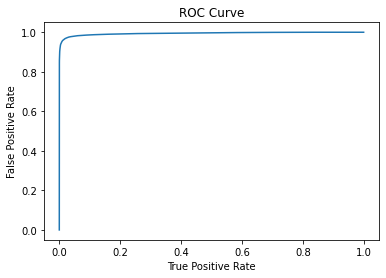

Training set Area Under ROC: 0.9945047229446977


In [100]:
# calculate the statistics summary for the Logistic Regression model
trainingSummary = lrModel.summary
# plot the ROC curve from the calculated summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set Area Under ROC: ' + str(trainingSummary.areaUnderROC))

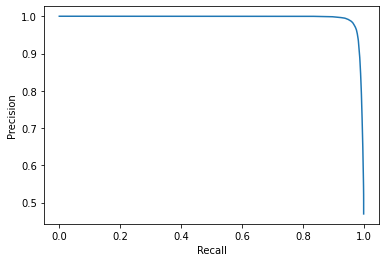

In [101]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [102]:
# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
print("objectiveHistory:")
for objective in objectiveHistory:
    print(objective)

# for multiclass, we can inspect metrics on a per-label basis
print("False positive rate by label:")
for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("True positive rate by label:")
for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("Precision by label:")
for i, prec in enumerate(trainingSummary.precisionByLabel):
    print("label %d: %s" % (i, prec))

print("Recall by label:")
for i, rec in enumerate(trainingSummary.recallByLabel):
    print("label %d: %s" % (i, rec))

print("F-measure by label:")
for i, f in enumerate(trainingSummary.fMeasureByLabel()):
    print("label %d: %s" % (i, f))

accuracy = trainingSummary.accuracy
falsePositiveRate = trainingSummary.weightedFalsePositiveRate
truePositiveRate = trainingSummary.weightedTruePositiveRate
fMeasure = trainingSummary.weightedFMeasure()
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
          % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))
# $example off$

objectiveHistory:
0.6912932324131177
0.4124023030909067
0.3330419714920459
0.26602589781804065
0.21760661606660064
0.18126221420338132
0.15422068998680039
0.13386345076893355
0.11741394405983124
0.10291807591032803
0.09126858695923426
False positive rate by label:


label 0: 0.03203837786941134
label 1: 0.0195520489771282
True positive rate by label:
label 0: 0.9804479510228719
label 1: 0.9679616221305887
Precision by label:
label 0: 0.9718860626954335
label 1: 0.9776912355497254
Recall by label:
label 0: 0.9804479510228719
label 1: 0.9679616221305887
F-measure by label:
label 0: 0.9761482329374732
label 1: 0.9728021014333146
Accuracy: 0.9745848309403384
FPR: 0.026175257786877928
TPR: 0.9745848309403384
F-measure: 0.9745770128462776
Precision: 0.9746119580196878
Recall: 0.9745848309403384


# Testing with the test dataset¶

In [103]:
predictions = lrModel.transform(test)
predictions.show(5)

+--------------------+------+--------------------+--------------------+----------+
|            features|labels|       rawPrediction|         probability|prediction|
+--------------------+------+--------------------+--------------------+----------+
|(210,[0,1,2,3,4,1...|   1.0|[-4.1343451913101...|[0.01576076775082...|       1.0|
|(210,[0,1,2,3,4,1...|   1.0|[-14.166707742471...|[7.03844457453830...|       1.0|
|(210,[0,1,2,3,4,1...|   1.0|[-14.166707742471...|[7.03844457453830...|       1.0|
|(210,[0,1,2,3,4,1...|   1.0|[-22.772689579098...|[1.28809109448537...|       1.0|
|(210,[0,1,2,3,4,1...|   1.0|[-71.534433023044...|[8.57019042884368...|       1.0|
+--------------------+------+--------------------+--------------------+----------+
only showing top 5 rows



In [104]:
# Area under ROC of the model
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='labels')
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.9748822423297547


In [105]:
evaluator = BinaryClassificationEvaluator(labelCol='labels')
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.9942944906552331


In [ ]:
# computing TruePositive, TrueNegative, FalsePositive, FalseNegative
predictions.groupBy('labels', 'prediction').count().show()
# Calculate the elements of the confusion matrix
TN = predictions.filter('prediction = 0 AND labels = prediction').count()
TP = predictions.filter('prediction = 1 AND labels = prediction').count()
FN = predictions.filter('prediction = 0 AND labels <> prediction').count()
FP = predictions.filter('prediction = 1 AND labels <> prediction').count()
# calculate accuracy, precision, recall, and F1-score
accuracy = (TN + TP) / (TN + TP + FN + FP)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
F = 2 * (precision*recall) / (precision + recall)
print('precision:', precision)
print('recall   :', recall)
print('accuracy :', accuracy)
print('F1 score :', F)

So, with the above metrics, we can conclude that the data can be modeled with very good accuracy when we only use 'successful' and 'failed' state project records.